In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

# ADSYN

In [2]:
# Scale data
split_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK3" 
train_x_df = pd.read_csv(split_path+"/NEK3_binding_random_fold1_trainX.csv")
train_y_df = pd.read_csv(split_path+"/NEK3_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(split_path+"/NEK3_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(split_path+"/NEK3_binding_random_fold1_testY.csv")
train_x = torch.from_numpy(train_x_df.to_numpy())
train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
test_x = torch.from_numpy(test_x_df.to_numpy())
test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))


x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

adasyn = ADASYN() 
train_x_temp, train_y_temp = adasyn.fit_resample(train_x, train_y_df)
train_x = train_x_temp
train_y = train_y_temp.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()

# # back to df for saving 
train_x_df = pd.DataFrame(train_x) 
train_y_df = pd.DataFrame(train_y) 
test_y_df = pd.DataFrame(test_y)
test_x_df = pd.DataFrame(test_x)

train_x_df.to_csv(split_path+'bind_train_x_ADASYN.csv', index=False, header=False)
train_y_df.to_csv(split_path+'bind_train_y_ADASYN.csv', index=False, header=False) 
test_y_df.to_csv(split_path+'bind_test_y_ADASYN.csv', index=False, header=False) 
test_x_df.to_csv(split_path+'bind_test_x_ADASYN.csv', index=False, header=False) 


# Load binding data 

In [3]:
split_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK3" 


train_x_df = pd.read_csv(split_path+'bind_train_x_ADASYN.csv')
train_y_df= pd.read_csv(split_path+'bind_train_y_ADASYN.csv')
test_x_df= pd.read_csv(split_path+'bind_test_x_ADASYN.csv')
test_y_df= pd.read_csv(split_path+'bind_test_y_ADASYN.csv')

train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape



((2112, 306), (2112,), (281, 306), (281,))

# ADASYN

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.858, precision: 0.103, recall: 0.176, sensitivity: 0.176, specificity: 0.902


<Figure size 600x400 with 0 Axes>

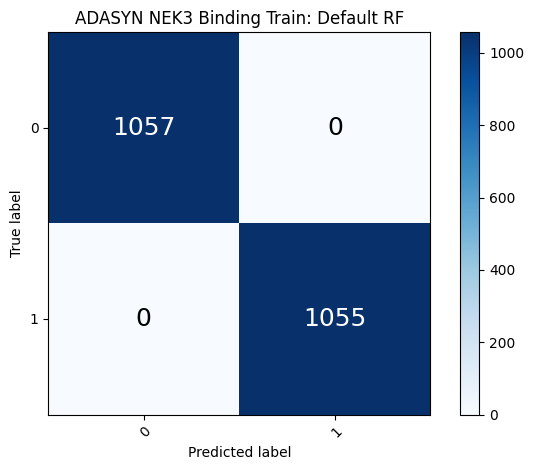

<Figure size 600x400 with 0 Axes>

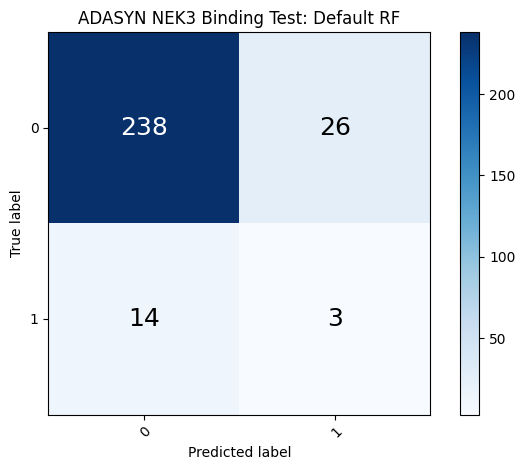

In [4]:
rf_basic100estADASYN= rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'binding')
plot_confusion_matrix(train_y, rf_basic100estADASYN['train_pred'], ['0','1'], title='ADASYN NEK3 Binding Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100estADASYN['test_pred'], ['0','1'], title='ADASYN NEK3 Binding Test: Default RF')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [5]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [7]:
save_file = 'atom_nek3bindADASYN_rf_basic_best.pkl'
# rf_basicbestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)

In [8]:
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbestADASYN['best_model'], f)

with open('saved_models/'+save_file, 'rb') as f: 
    rf_basicbestADASYN = pickle.load(f) 
gridresults1 = rf_results2(rf_basicbestADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults1['test_pred'], ['0','1'], title='ADASYN NEK3 Bind Test (Grid): Default RF')



FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/atom_nek3bindADASYN_rf_basic_best.pkl'

In [12]:
for param, value in rf_basicbestADASYN.get_params().items():
    print(f'{param}: {value}')

NameError: name 'rf_basicbestADASYN' is not defined

# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.843, precision: 0.065, recall: 0.118, sensitivity: 0.118, specificity: 0.890


<Figure size 600x400 with 0 Axes>

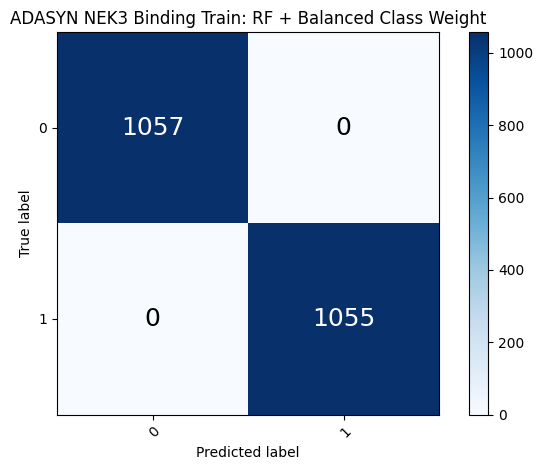

<Figure size 600x400 with 0 Axes>

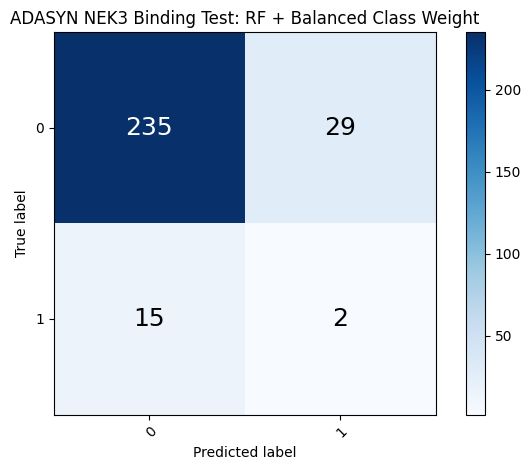

In [11]:
brf_model_BCW_ADASYN = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'binding')
plot_confusion_matrix(train_y, brf_model_BCW_ADASYN['train_pred'], ['0','1'], title='ADASYN NEK3 Binding Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW_ADASYN['test_pred'], ['0','1'], title='ADASYN NEK3 Binding Test: RF + Balanced Class Weight')

In [13]:
save_file2 = 'atom_nek3bindADASYN_rf_basicBCW_best.pkl'
# rf_basicBCWbestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)
# with open(save_file2, 'rb') as f: 
#     rf_basicBCWbestADASYN = pickle.load(f) 


In [14]:
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbestADASYN['best_model'], f)


with open('saved_models/'+save_file2, 'rb') as f: 
    gridRF_BCW_ADASYN = pickle.load(f) 
gridresults2 = rf_results2(gridRF_BCW_ADASYN, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults2['test_pred'], ['0','1'], title='ADASYN NEK3 Bind Test (Grid): RF + Bal Class Weight')



FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/atom_nek3bindADASYN_rf_basicBCW_best.pkl'

In [14]:
for param,value in gridRF_BCW_ADASYN.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 220
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.854, precision: 0.100, recall: 0.176, sensitivity: 0.176, specificity: 0.898


<Figure size 600x400 with 0 Axes>

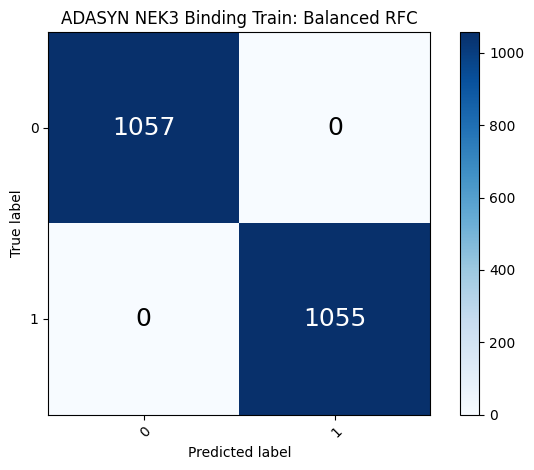

<Figure size 600x400 with 0 Axes>

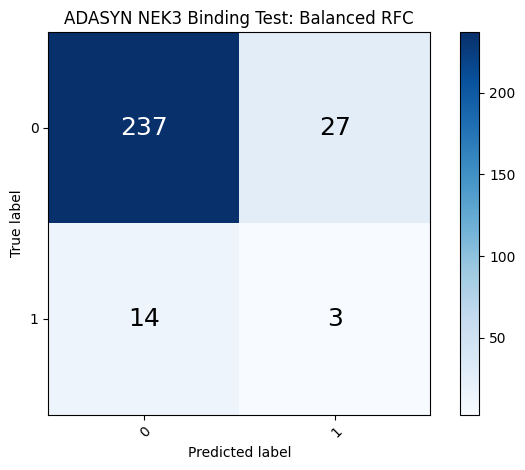

In [15]:
brf_modelADASYN = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'binding')
plot_confusion_matrix(train_y, brf_modelADASYN['train_pred'], ['0','1'], title='ADASYN NEK3 Binding Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_modelADASYN['test_pred'], ['0','1'], title='ADASYN NEK3 Binding Test: Balanced RFC')

In [ ]:
# save_file3 = 'atom_nek2bindADASYN_BRFC_best.pkl'
# brfc_bestADASYN = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, param_grid,  save_file3, 2)



In [16]:
# for param, value in brfc_bestADASYN.get_params().items():
#     print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.851, precision: 0.069, recall: 0.118, sensitivity: 0.118, specificity: 0.898


<Figure size 600x400 with 0 Axes>

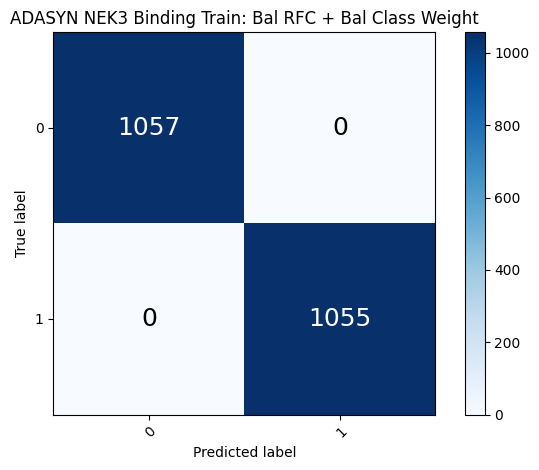

<Figure size 600x400 with 0 Axes>

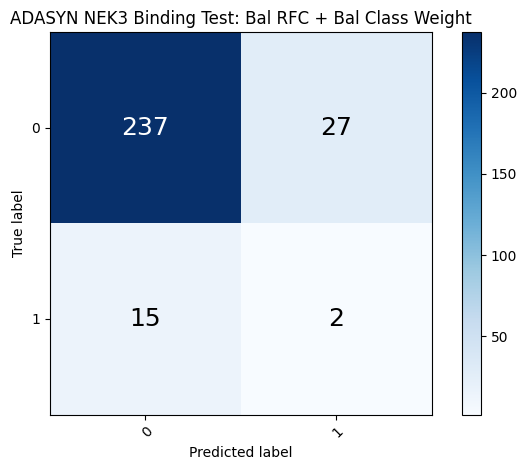

In [16]:
brf_modelCWB_ADASYN = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'binding')
plot_confusion_matrix(train_y, brf_modelCWB_ADASYN['train_pred'], ['0','1'], title='ADASYN NEK3 Binding Train: Bal RFC + Bal Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB_ADASYN['test_pred'], ['0','1'], title='ADASYN NEK3 Binding Test: Bal RFC + Bal Class Weight')

In [15]:
for param, value in brfc_BCW_ADASYN_best.get_params().items():
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: entropy
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [19]:
nek2bind_ADASYNmodels

{'default_RF': RandomForestClassifier(bootstrap=False, max_depth=200, max_features=None,
                        min_samples_leaf=2, min_samples_split=4,
                        n_estimators=1050),
 'rf_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=220,
                        max_features=None, min_samples_leaf=2),
 'BRFC': RandomForestClassifier(bootstrap=False, max_depth=100, max_features=None,
                        min_samples_leaf=2, min_samples_split=4),
 'BRFC_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=100, max_features=None,
                        min_samples_leaf=2)}